In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.resolve()
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 

  Activating project at `c:\Users\Daniel\Documents\Python-Projects\ocrl-piano\single_finger_and_key`
  No Changes to `C:\Users\Daniel\Documents\Python-Projects\ocrl-piano\single_finger_and_key\Project.toml`
  No Changes to `C:\Users\Daniel\Documents\Python-Projects\ocrl-piano\single_finger_and_key\Manifest.toml`


In [2]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))

fmincon (generic function with 1 method)

In [3]:
function fingertip_forward_kinematics(params::NamedTuple, x::Vector)
    L1, L2, L3, m1, m2, m3, k, b, mkey, ykey = params.L1, params.L2, params.L3, params.m1, params.m2, params.m3, params.k, params.b, params.mkey, params.ykey
    
    q = x[1:3]
    # qd = x[4:6]
    s1 = sin(q[1])
    s2 = sin(q[2])
    s3 = sin(q[3])

    c1 = cos(q[1])
    c2 = cos(q[2])
    c3 = cos(q[3])

    s1p2 = sin(q[1] + q[2])
    s2p3 = sin(q[2] + q[3])

    c1p2 = cos(q[1] + q[2])
    c2p3 = cos(q[2] + q[3])

    s1p2p3 = sin(q[1] + q[2] + q[3])
    c1p2p3 = cos(q[1] + q[2] + q[3])

    x3 = L1*c1 + L2*c1p2 + L3*c1p2p3
    y3 = L1*s1 + L2*s1p2 + L3*s1p2p3

    return [x3; y3]

end

function fingertip_jacobian(params::NamedTuple, x::Vector)
    L1, L2, L3 = params.L1, params.L2, params.L3

    # Jacobian of the finger tip position with respect to the joint angles
    q = x[1:3]
    qd = x[4:6]

    s1 = sin(q[1])
    s2 = sin(q[2])
    s3 = sin(q[3])

    c1 = cos(q[1])
    c2 = cos(q[2])
    c3 = cos(q[3])

    s1p2 = sin(q[1] + q[2])
    s2p3 = sin(q[2] + q[3])

    c1p2 = cos(q[1] + q[2])
    c2p3 = cos(q[2] + q[3])

    s1p2p3 = sin(q[1] + q[2] + q[3])
    c1p2p3 = cos(q[1] + q[2] + q[3])

    J = [-L1*s1-L2*s1p2-L3*s1p2p3 -L2*s1p2-L3*s1p2p3 -L3*s1p2p3;
    L1*c1+L2*c1p2+L3*c1p2p3 L2*c1p2+L3*c1p2p3 L3*c1p2p3]

    return J
end

fingertip_jacobian (generic function with 1 method)

In [45]:
function finger_dynamics(params::NamedTuple, x::Vector, u)
    # cartpole ODE, parametrized by params. 
    L1, L2, L3, m1, m2, m3 = params.L1, params.L2, params.L3, params.m1, params.m2, params.m3

    q = x[1:3]
    qd = x[4:6]

    s1 = sin(q[1])
    s2 = sin(q[2])
    s3 = sin(q[3])

    c1 = cos(q[1])
    c2 = cos(q[2])
    c3 = cos(q[3])

    s1p2 = sin(q[1] + q[2])
    s2p3 = sin(q[2] + q[3])

    c1p2 = cos(q[1] + q[2])
    c2p3 = cos(q[2] + q[3])


    # M = [m1*L1^2 + m2*(L1^2+2*m2*L1*L2*c2 + L2^2) + m3*(L1^2 + 2*L1*L2*c2 + L2^2 + 2*L2*L3*c3 + 2*L1*L3*c2p3 + L3^2) ;;
    # m2*(L2^2 + L1*L2*c2) + m3*(L1*L2*c2 + L1*L3*c2p3 + 2*L2*L3*c3) ;;
    # m3*L2*L3*c3 # torque 1
    # m2*(L2^2 + L1*L2*c2) + m3*(L1*L2*c2 + L1*L3*c2p3 + 2*L2*L3*c3) ;;
    # m2*L2^2 + m3*(L2*L3*c3 + L3^2) ;;
    # m3*L2*L3 # torque 2
    # m3*L2*L3*c3 ;;
    # m3*L2*L3 ;;
    # m3*L3^2] # torque 3

    
    M = [m1*L1^2 + m2*(L1^2+2*m2*L1*L2*c2 + L2^2) + m3*(L1^2 + 2*L1*L2*c2 + L2^2 + 2*L2*L3*c3 + 2*L1*L3*c2p3 + L3^2) m2*(L2^2 + L1*L2*c2) + m3*(L1*L2*c2 + L1*L3*c2p3 + 2*L2*L3*c3) m3*L2*L3*c3 # torque 1
         m2*(L2^2 + L1*L2*c2) + m3*(L1*L2*c2 + L1*L3*c2p3 + 2*L2*L3*c3) m2*L2^2 + m3*(L2*L3*c3 + L3^2) m3*L2*L3 # torque 2
         m3*L2*L3*c3 m3*L2*L3 m3*L3^2] # torque 3

    qdd = M\u
    xdot = [qd; qdd]
    return xdot
end

function key_fall_dynamics(params::NamedTuple, x::Vector, u)
    # cartpole ODE, parametrized by params. 
    L1, L2, L3, m1, m2, m3, k, b, mkey, ykey = params.L1, params.L2, params.L3, params.m1, params.m2, params.m3, params.k, params.b, params.mkey, params.ykey

    q = x[1:3]
    qd = x[4:6]

    s1 = sin(q[1])
    s2 = sin(q[2])
    s3 = sin(q[3])

    c1 = cos(q[1])
    c2 = cos(q[2])
    c3 = cos(q[3])

    s1p2 = sin(q[1] + q[2])
    s2p3 = sin(q[2] + q[3])

    c1p2 = cos(q[1] + q[2])
    c2p3 = cos(q[2] + q[3])

    s1p2p3 = sin(q[1] + q[2] + q[3])
    c1p2p3 = cos(q[1] + q[2] + q[3])


    y3 = L1*s1 + L2*s1p2 + L3*s1p2p3
    y3dot = L1*qd[1]*c1 + L2*(qd[1] + qd[2])*c1p2 + L3*(qd[1] + qd[2] + qd[3])*c1p2p3 

    f_key = k*(ykey - y3) + b*y3dot
    m3 = m3 + mkey # mass at fingertip increases by key mass

    M = [m1*L1^2 + m2*(L1^2+2*m2*L1*L2*c2 + L2^2) + m3*(L1^2 + 2*L1*L2*c2 + L2^2 + 2*L2*L3*c3 + 2*L1*L3*c2p3 + L3^2) m2*(L2^2 + L1*L2*c2) + m3*(L1*L2*c2 + L1*L3*c2p3 + 2*L2*L3*c3) m3*L2*L3*c3 # torque 1
         m2*(L2^2 + L1*L2*c2) + m3*(L1*L2*c2 + L1*L3*c2p3 + 2*L2*L3*c3) m2*L2^2 + m3*(L2*L3*c3 + L3^2) m3*L2*L3 # torque 2
         m3*L2*L3*c3 m3*L2*L3 m3*L3^2] # torque 3

    # Compute the joint to tip velocity jacobian
    J = [-L1*s1-L2*s1p2-L3*s1p2p3 -L2*s1p2-L3*s1p2p3 -L3*s1p2p3;
        L1*c1+L2*c1p2+L3*c1p2p3 L2*c1p2+L3*c1p2p3 L3*c1p2p3]

    qdd = M\(u + J'*[0, f_key])
    xdot = [qd; qdd]
    return xdot
end

function jump1_map(params::NamedTuple, x::Vector)
    L1, L2, L3, m1, m2, m3, k, b, mkey, ykey = params.L1, params.L2, params.L3, params.m1, params.m2, params.m3, params.k, params.b, params.mkey, params.ykey

    q = x[1:3]
    qd = x[4:6]

    s1 = sin(q[1])
    s2 = sin(q[2])
    s3 = sin(q[3])

    c1 = cos(q[1])
    c2 = cos(q[2])
    c3 = cos(q[3])

    s1p2 = sin(q[1] + q[2])
    s2p3 = sin(q[2] + q[3])

    c1p2 = cos(q[1] + q[2])
    c2p3 = cos(q[2] + q[3])

    s1p2p3 = sin(q[1] + q[2] + q[3])
    c1p2p3 = cos(q[1] + q[2] + q[3])

    J = [-L1*s1-L2*s1p2-L3*s1p2p3 -L2*s1p2-L3*s1p2p3 -L3*s1p2p3;
    L1*c1+L2*c1p2+L3*c1p2p3 L2*c1p2+L3*c1p2p3 L3*c1p2p3]

    v_tip = J*x[4:6] # forward kinematics to find finger tip velocity

    # Solve for post collision finger tip velocity
    v_tip_x_post = 0 # zero out x velocity 
    v_tip_y_post = m3*v_tip[2]/(m3 + mkey) # assume inelastic collision when finger contacts key

    # Solve for post collision joint velocities based on tip velocity
    qd_post = J\[v_tip_x_post; v_tip_y_post]

    return [q; qd_post]
end

function jump2_map(params::NamedTuple, x::Vector)
    L1, L2, L3, m1, m2, m3, k, b, mkey, ykey = params.L1, params.L2, params.L3, params.m1, params.m2, params.m3, params.k, params.b, params.mkey, params.ykey
    
    q = x[1:3]
    qd = x[4:6]

    s1 = sin(q[1])
    s2 = sin(q[2])
    s3 = sin(q[3])

    c1 = cos(q[1])
    c2 = cos(q[2])
    c3 = cos(q[3])

    s1p2 = sin(q[1] + q[2])
    s2p3 = sin(q[2] + q[3])

    c1p2 = cos(q[1] + q[2])
    c2p3 = cos(q[2] + q[3])

    s1p2p3 = sin(q[1] + q[2] + q[3])
    c1p2p3 = cos(q[1] + q[2] + q[3])

    J = [-L1*s1-L2*s1p2-L3*s1p2p3 -L2*s1p2-L3*s1p2p3 -L3*s1p2p3;
    L1*c1+L2*c1p2+L3*c1p2p3 L2*c1p2+L3*c1p2p3 L3*c1p2p3]


    # Zero out tip velocities
    v_tip_x_post = 0 
    v_tip_y_post = 0 
    
    # Solve for post collision joint velocities based on tip velocity
    qd_post = J\[v_tip_x_post; v_tip_y_post]

    return [q; qd_post]
end


function rk4(params::NamedTuple, ode::Function, x::Vector, u::Vector, dt::Real)::Vector
    k1 = dt * ode(params, x,        u)
    k2 = dt * ode(params, x + k1/2, u)
    k3 = dt * ode(params, x + k2/2, u)
    k4 = dt * ode(params, x + k3,   u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end  

function hermite_simpson(params::NamedTuple, ode::Function, x1::Vector, x2::Vector, u, dt::Real)::Vector
    # TODO: input hermite simpson implicit integrator residual 
    ẋ1 = ode(params, x1, u)
    ẋ2 = ode(params, x2, u)
    xm = (1/2)*(x1 + x2) + (dt/8)*(ẋ1 - ẋ2)
    ẋm = ode(params, xm, u)
    x1 + (dt/6)*(ẋ1 + 4*ẋm + ẋ2) - x2
end

hermite_simpson (generic function with 1 method)

Define Contact Sequence

In [46]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # Feel free to use/not use anything here.
    
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function finger_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
  
    
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
       
        J += 0.5*(xi - xg)'*Q*(xi - xg)
        J += 0.5*ui'*R*ui 
    end
    
    xn = Z[idx.x[N]]
    J += 0.5*(xn - xg)'*Qf*(xn - xg)
    
    return J 
end

function stage_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    # @show Z

    xi = Z[1:6]
    ui = Z[7:9]
    # @show xg
    # @show xi
    J = 0
    J += 0.5*(xi - xg)'*Q*(xi - xg)
    J +=  0.5*ui'*R*ui 
    return J 
end

function fingertip_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf

    fingertip_xg = fingertip_forward_kinematics(params, xg)

    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
       
        fingertip_xi = fingertip_forward_kinematics(params, xi)
        J += 0.5*(fingertip_xi - fingertip_xg)'*Q*(fingertip_xi - fingertip_xg)
        J += 0.5*ui'*R*ui 
    end
    
    xn = Z[idx.x[N]]
    fingertip_xn = fingertip_forward_kinematics(params, xn)
    J += 0.5*(fingertip_xn - fingertip_xg)'*Qf*(fingertip_xn - fingertip_xg)
    
    return J 
end

function finger_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    M1, M2, M3 = params.M1, params.M2, params.M3
    J1, J2 = params.J1, params.J2 

    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]    

        # c[idx.c[i]] = hermite_simpson(params, key_fall_dynamics, xi, xip1, ui, dt)
        if (i in J1)
            c[idx.c[i]] = jump1_map(params, rk4(params, finger_dynamics, xi, ui, dt)) - xip1
            # c[idx.c[i]] = hermite_simpson(params, finger_dynamics, xi, xip1, ui, dt)
        
        elseif (i in J2)
            c[idx.c[i]] = jump2_map(params, rk4(params, key_fall_dynamics, xi, ui, dt)) - xip1
            # c[idx.c[i]] = hermite_simpson(params, key_fall_dynamics, xi, xip1, ui, dt)
        
        elseif (i in M1)
            c[idx.c[i]] = hermite_simpson(params, finger_dynamics, xi, xip1, ui, dt)
        
        elseif (i in M2) 
            c[idx.c[i]] = hermite_simpson(params, key_fall_dynamics, xi, xip1, ui, dt)
         
        elseif (i in M3)
            c[idx.c[i]] = hermite_simpson(params, finger_dynamics, xi, xip1, ui, dt)
            # c[idx.c[i]] = [zeros(3); xi[4:6]]
            # c[idx.c[i]] = [zeros(3); zeros(3)]

        end
    end
    return c 
end

function finger_mode_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    M1, M2, M3 = params.M1, params.M2, params.M3
    J1, J2 = params.J1, params.J2 
    
    L1, L2, L3, m1, m2, m3, k, b, mkey, ykey = params.L1, params.L2, params.L3, params.m1, params.m2, params.m3, params.k, params.b, params.mkey, params.ykey
    
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), N)
 
    for k = 1:N 
        x = Z[idx.x[k]]

        s1 = sin(x[1])
        s2 = sin(x[2])
        s3 = sin(x[3])
    
        c1 = cos(x[1])
        c2 = cos(x[2])
        c3 = cos(x[3])
    
        s1p2 = sin(x[1] + x[2])
        s2p3 = sin(x[2] + x[3])
    
        c1p2 = cos(x[1] + x[2])
        c2p3 = cos(x[2] + x[3])
    
        s1p2p3 = sin(x[1] + x[2] + x[3])
        c1p2p3 = cos(x[1] + x[2] + x[3])
    
        J = [-L1*s1-L2*s1p2-L3*s1p2p3 -L2*s1p2-L3*s1p2p3 -L3*s1p2p3;
        L1*c1+L2*c1p2+L3*c1p2p3 L2*c1p2+L3*c1p2p3 L3*c1p2p3]
        
        # if (k in M1)
        #     # c[k] = x[4]
        # elseif (k in M2)
        #     v_tip = J*x[4:6]
        #     c[k] = v_tip[1] # zero out x velocity
        # elseif (k in M3)
        #     v_tip = J*x[4:6]
        #     c[k] = 100*norm(v_tip)^2 # zero out x and y velocity
        #     # c[k] = norm(x[4:6])
        #     # c[k] = 0
        # end
        if (k in M3)
            v_tip = J*x[4:6]
            c[k] = 5*norm(v_tip)^2 # zero out x and y velocity
        end
    end

    return c
end

function finger_equality_constraints(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    
    return [
        Z[idx.x[1]] - xic;
        Z[idx.x[N]] - xg;
        finger_dynamics_constraints(params, Z);
        # finger_mode_constraints(params, Z)
    ]
end

function finger_inequality_constraint(params, Z)
    return zeros(eltype(Z), 0)
    # return finger_mode_constraints(params, Z)
end

finger_inequality_constraint (generic function with 1 method)

In [47]:
function solve_finger_strike(;verbose=true)
    # problem size 
    nx = 6 
    nu = 3 
    dt = 0.01
    tf = 0.5 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # LQR cost 
    Q = 10*diagm(ones(nx))
    R = 1*diagm(ones(nu))
    Qf = 10*diagm(ones(nx))
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states 
    xic = [deg2rad(45), -deg2rad(45), 0, 0, 0, 0]


    # fingertip_xg = [0.2, -0.1]
    # xg = pinv(fingertip_jacobian(fingertip_xgfingertip_xg))*
    xg = [deg2rad(30), -deg2rad(35), -deg2rad(25), 0.0, 0.0, 0.0]
 

    # mode index sets
    # M1 = vcat([1:50]...)
    # M2 = vcat([26:35]...)
    # M3 = vcat([36:50]...)
    M1 = vcat([1:50]...)
    M2 = vcat([26:35]...)
    M3 = vcat([36:50]...)
    # M2 = []
    # M3 = []

    J1 = [25]
    J2 = [35]
    # J1 = []
    # J2 = []
    
    
    # load all useful things into params 
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx, L1=0.1, L2=0.1,
     L3=0.1, m1=1.0, m2=1.0, m3=0.25, k=0.01, b=0.0, mkey=0.1, ykey=0.0, M1=M1, M2=M2, M3=M3, J1=J1, J2=J2)

    # load all useful things into params 
    # params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx, L1=4.5, L2=2.5,
    # L3=2.5, m1=0.03, m2=0.017, m3=0.013, k=0.1, b=0.1, mkey=0.50, ykey=0.0, M1=M1, M2=M2, M3=M3, J1=J1, J2=J2)
    
    # TODO: primal bounds 
    x_l = -Inf*ones(idx.nz)
    x_u =  Inf*ones(idx.nz)
    
    # bounds on u 
    u_min = -10.0
    u_max =  10.0 
    
    for i = 1:(N-1)
        x_l[idx.u[i]] .= u_min 
        x_u[idx.u[i]] .= u_max 
    end
    

    # inequality constraint bounds (this is what we do when we have no inequality constraints)
    c_l = zeros(0)
    c_u = zeros(0)
    
    # initial guess 
    z0 = 0.001*randn(idx.nz)
    
    # choose diff type (try :auto, then use :finite if :auto doesn't work)
    diff_type = :auto 
#     diff_type = :finite
    
    
    Z = fmincon(finger_cost,finger_equality_constraints,finger_inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 500, verbose = verbose)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, t_vec, params 
end



solve_finger_strike (generic function with 1 method)

In [48]:
X, U, t_vec = solve_finger_strike(verbose=true)

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:   142272
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      456
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      150
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints......

([[0.7853981633974483, -0.7853981633974483, 0.0, -1.4988258269594659e-33, 0.0, 0.0], [0.7844155455742703, -0.7848519520866902, -0.0020053758296740367, -0.19652518290990018, 0.1092511311248234, -0.40108248249689443], [0.7819887055511722, -0.7839714200816134, -0.006024660386023313, -0.28884167388920523, 0.0668557954341684, -0.40277635042064625], [0.7788009816641984, -0.7834452572387115, -0.010046407219918832, -0.34870360168103287, 0.038376341374545694, -0.40157240885256623], [0.7751214171129858, -0.783158110718365, -0.014051024108752789, -0.3872102038862044, 0.019052417672624278, -0.39934983828868464], [0.7711269191322105, -0.7830340834914458, -0.018030158626856207, -0.41169025213288696, 0.0057526387409753054, -0.3964760770171882], [0.7669336763962146, -0.783023217946416, -0.021978476124208148, -0.4269590017598439, -0.0035797110954194572, -0.3931867355254315], [0.7626179910624026, -0.7830926079589016, -0.025892595195941434, -0.43617861375474165, -0.010298286965351533, -0.3896366786090469

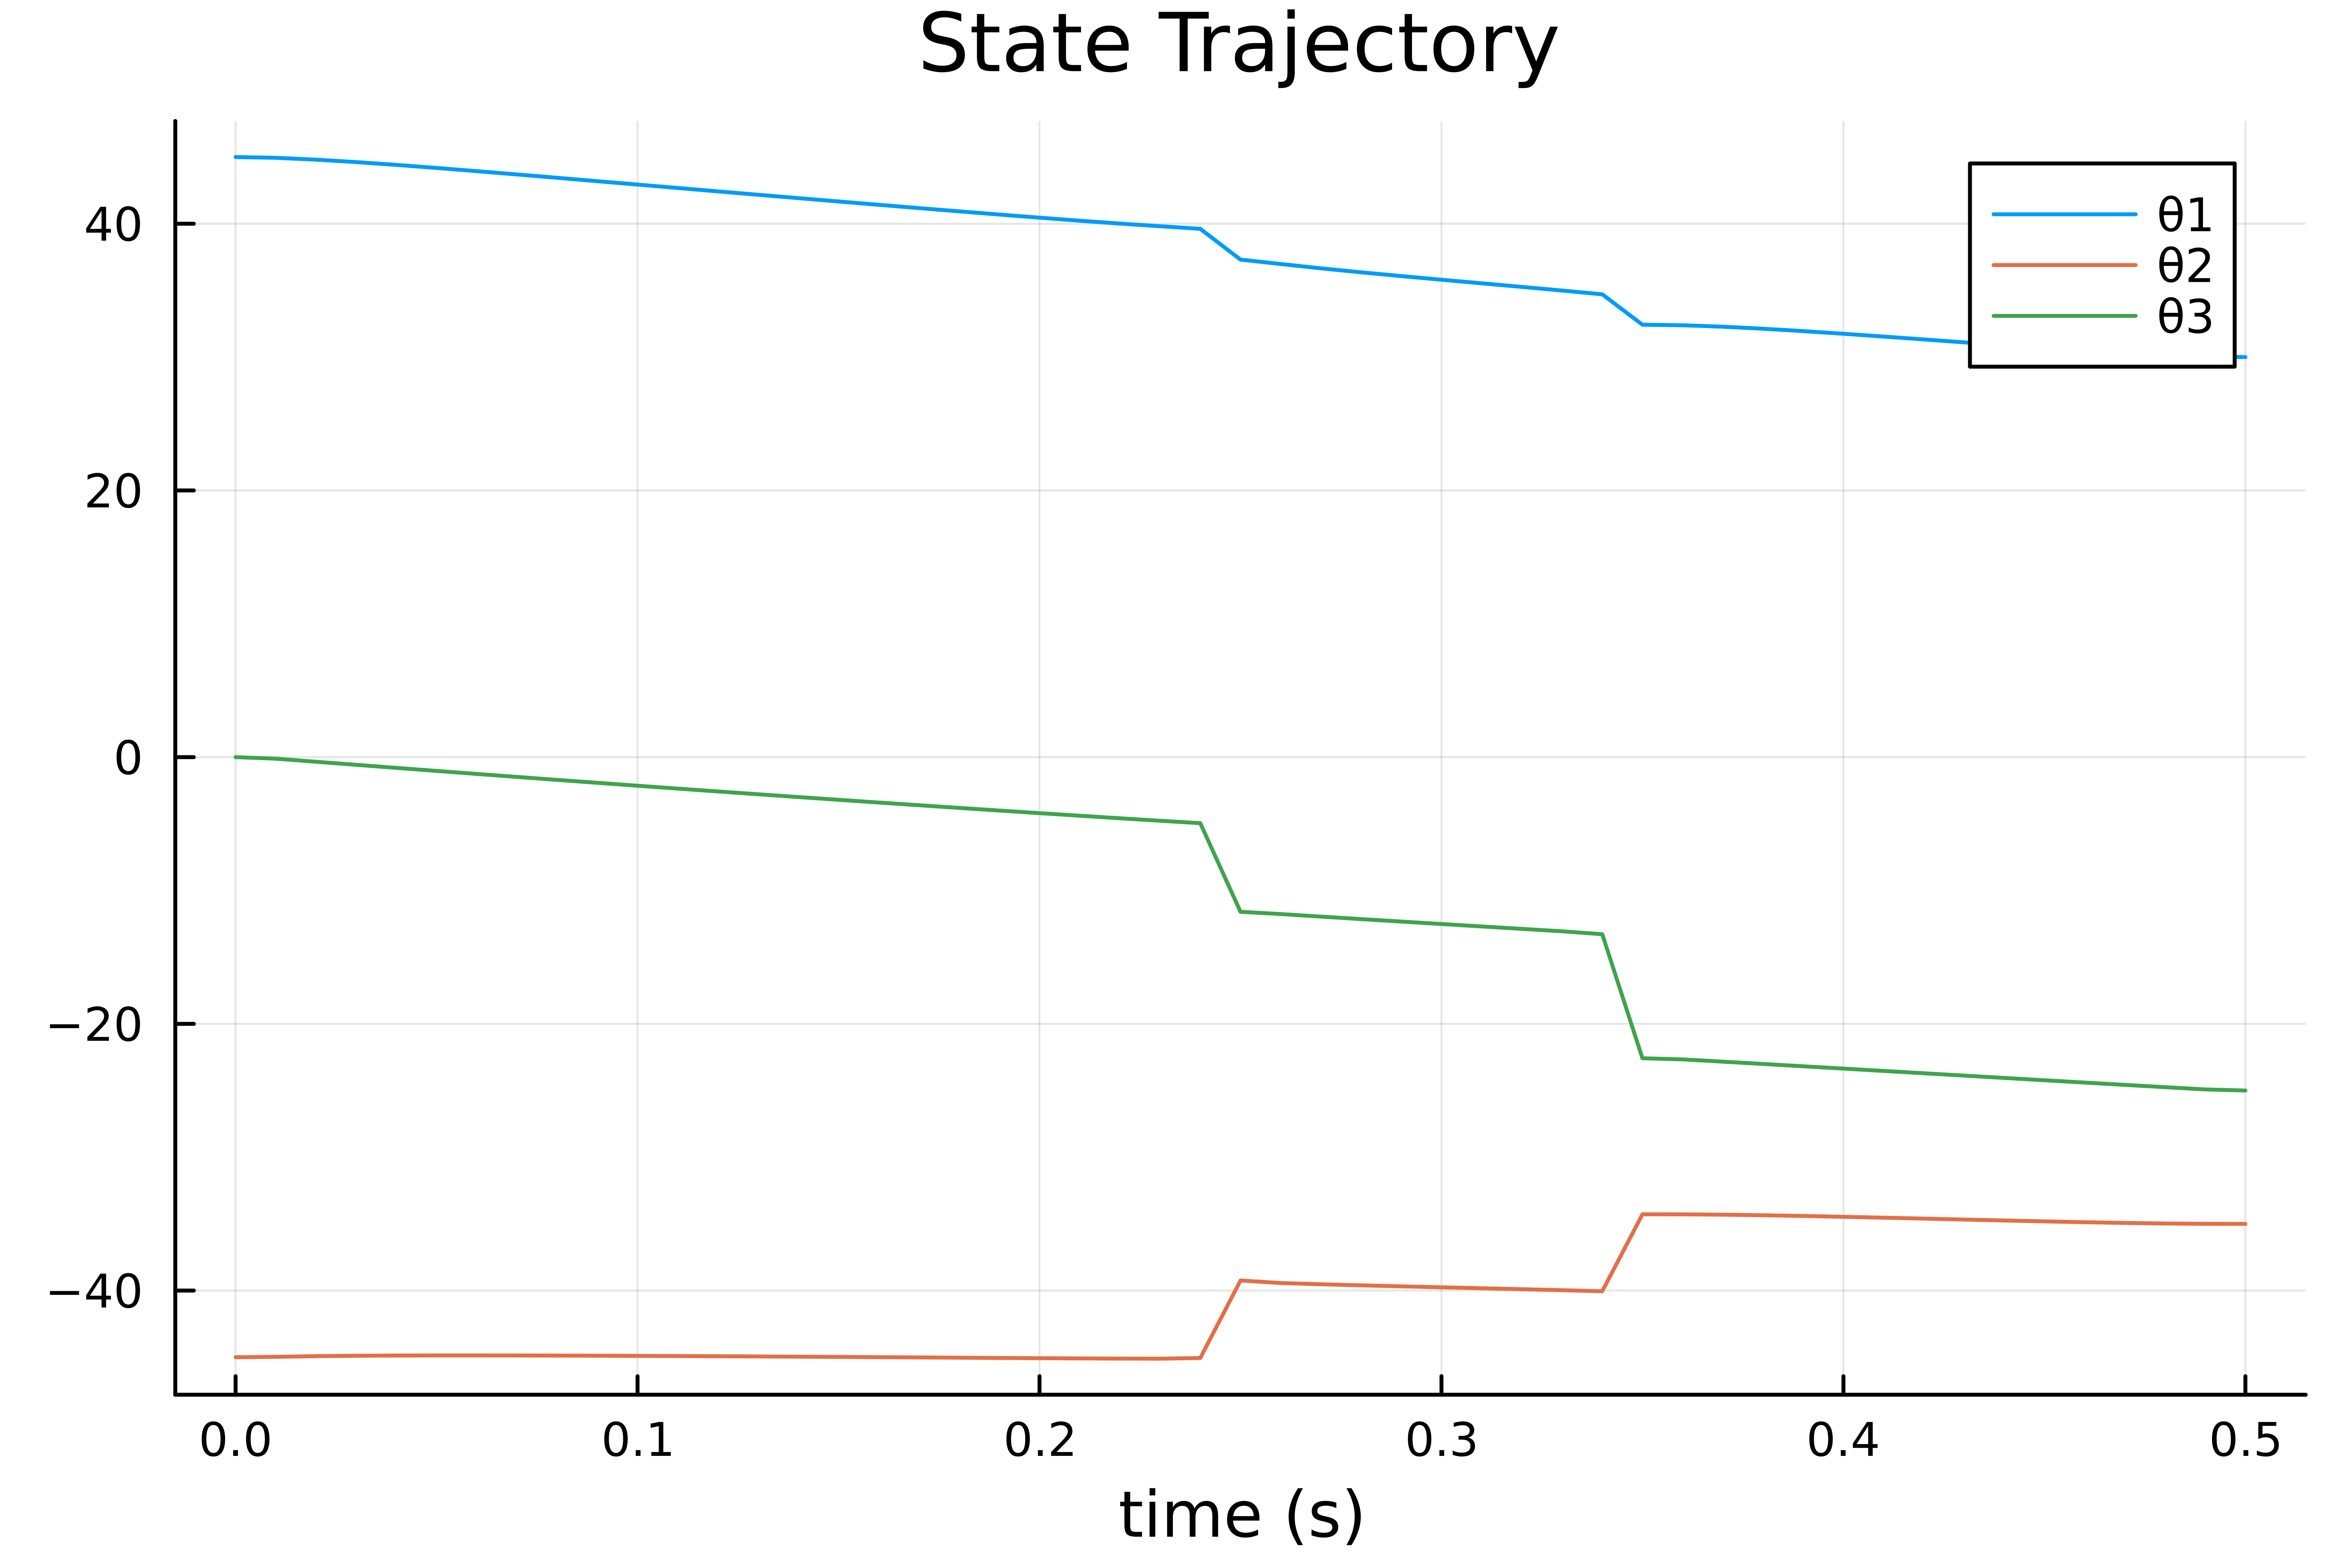

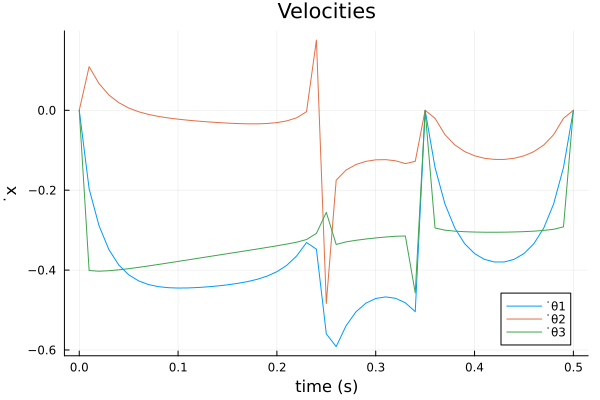

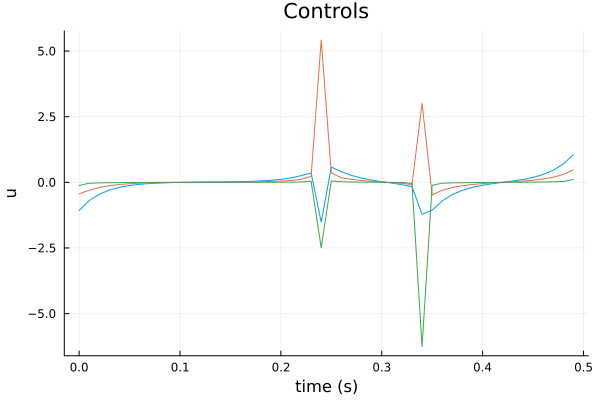

"c:\\Users\\Daniel\\Documents\\Python-Projects\\ocrl-piano\\single_finger_and_key\\controls.png"

In [49]:
Xm = hcat(X...)
Um = hcat(U...)
default(show = true)

# # --------------plotting-----------------
display(plot(t_vec, (180/pi)*Xm[1:3,:]', label = ["θ1" "θ2" "θ3" ], xlabel = "time (s)", title = "State Trajectory", dpi=1000))
display(plot(t_vec,Xm[4:6,:]',label= ["̇θ1" "̇θ2" "̇θ3"], xlabel = "time (s)", ylabel = "̇x",title = "Velocities"))
display(plot(t_vec[1:end-1],Um',label="",xlabel = "time (s)", ylabel = "u",title = "Controls"))
Xm = hcat(X...)
Um = hcat(U...)
default(show = true)

# --------------plotting-----------------
p1 = plot(t_vec, (180/pi)*Xm[1:3,:]', label = ["θ1" "θ2" "θ3" ], xlabel = "time (s)", title = "State Trajectory", dpi=1000)
p2 = plot(t_vec,Xm[4:6,:]',label= ["̇θ1" "̇θ2" "̇θ3"], xlabel = "time (s)", ylabel = "̇x",title = "Velocities", dpi=1000)
p3 = plot(t_vec[1:end-1],Um',label="",xlabel = "time (s)", ylabel = "u",title = "Controls", dpi=1000)

savefig(p1, "state_trajectory.png")
savefig(p2, "velocities.png")
savefig(p3, "controls.png")

# # meshcat animation
# display(animate_cartpole(X, 0.05))


In [9]:
X
Xm

6×51 Matrix{Float64}:
  0.785398      0.78443      0.782045   …   0.526157    0.5243      0.523599
 -0.785398     -0.784817    -0.783862      -0.610313   -0.61075    -0.610865
  2.07401e-36  -0.00214616  -0.0064472     -0.431382   -0.434693   -0.436332
  0.0          -0.193622    -0.283374      -0.23115    -0.140235    0.0
  0.0           0.116237     0.0747882     -0.0642344  -0.0230563   0.0
  0.0          -0.42924     -0.430971   …  -0.334245   -0.327903    0.0

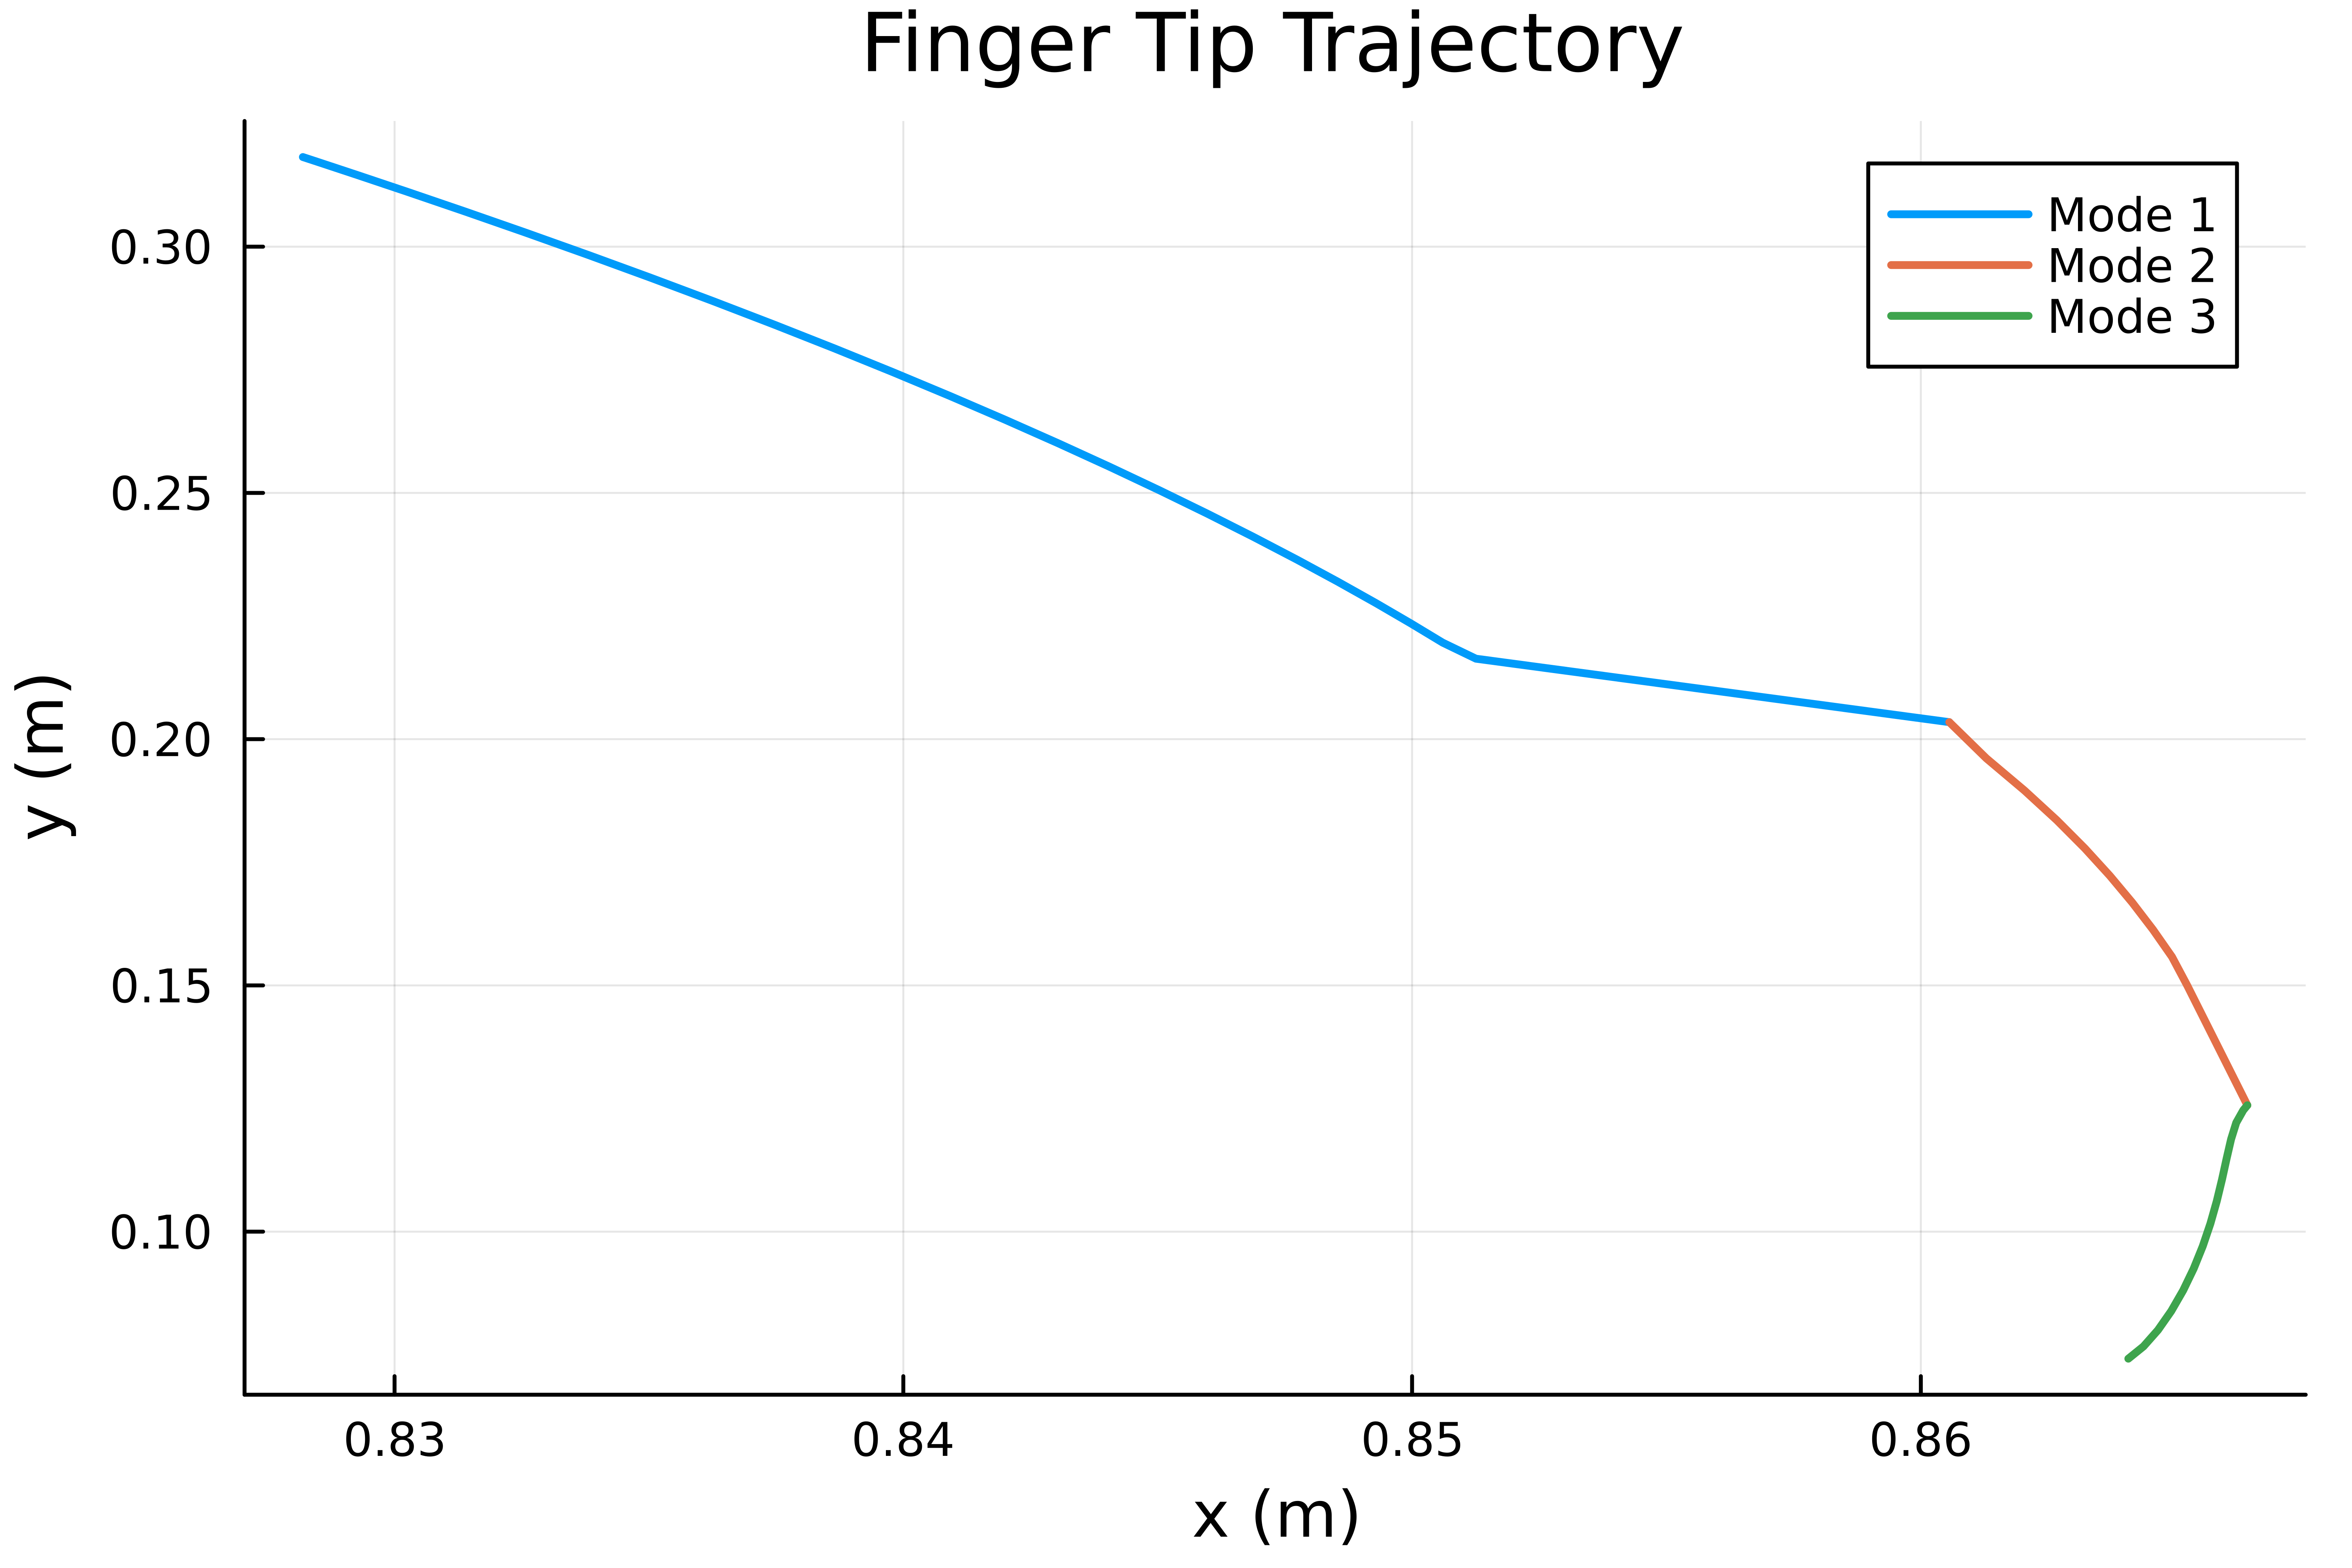

[0.7853981633974483 0.7844155455742703 0.7819887055511722 0.7788009816641984 0.7751214171129858 0.7711269191322105 0.7669336763962146 0.7626179910624026 0.7582299796680061 0.7538025919888066 0.7493575660798941 0.7449093843545685 0.740467936733726 0.7360403657960229 0.731632423063644 0.7272495786561006 0.7228980829639976 0.7185861710810092 0.7143256270779568 0.7101339907476566 0.7060378060059244 0.7020774953792798 0.6983146133951141 0.6948368468973658 0.6914435430020072 0.6511600420938177 0.6454033533852973 0.6397492130732786 0.634530340214938 0.6295933644413803 0.6248234394090949 0.6201323484362454 0.6154435906987841 0.6106810760566213 0.6057511422624782 0.5659525195202354 0.5652383765266336 0.5633534895985375 0.5607094952371874 0.5575665710379114 0.5541035273766698 0.5504445327512453 0.5466801233629277 0.5428826159357785 0.5391184715951121 0.5354597149453549 0.5319963587417672 0.5288519602594931 0.5262048930639152 0.524315489861469 0.5235987755982988; -0.7853981633974483 -0.7848519520

"c:\\Users\\Daniel\\Documents\\Python-Projects\\ocrl-piano\\single_finger_and_key\\finger_tip_traj.png"

In [50]:
# Plot finger tip position
println(Xm)


Xm_vec = [Vector(col) for col in eachcol(Xm)]

# Params
nx = 6 
nu = 3 
dt = 0.01
tf = 0.5 
t_vec = 0:dt:tf 
N = length(t_vec)

# LQR cost 
Q = 10*diagm(ones(nx))
R = diagm(ones(nu))
Qf = 10*diagm(ones(nx))

# indexing 
idx = create_idx(nx,nu,N)

# initial and goal states 
xic = [0, 0, 0, 0, 0, 0]
xg = [deg2rad(10), deg2rad(45), deg2rad(10), 0.0, 0.0, 0.0]


# mode index sets
M1 = vcat([1:25]...)
M2 = vcat([26:35]...)
M3 = vcat([36:50]...)
# M2 = []
# M3 = []

J1 = [25]
J2 = [35]


params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx, L1=0.45, L2=0.25,
    L3=0.26, m1=1.0, m2=1.0, m3=0.25, k=50, b=0.1, mkey=2.5, ykey=0.0, M1=M1, M2=M2, M3=M3, J1=J1, J2=J2)

fingertip_pos = [fingertip_forward_kinematics(params, x) for x in Xm_vec]
fingertip_vel = [fingertip_jacobian(params, x)*x[4:6] for x in Xm_vec]

# for x in Xm_vec
#     fingertip = fingertip_forward_kinematics(params, x)
#     plot!(fingertip[1], fingertip[2], seriestype = :scatter, markersize = 5, label = "")
# end


Xm_fingertip = hcat(fingertip_pos...)
Xm_fingertip_vel = hcat(fingertip_vel...) 

plot(Xm_fingertip[1,1:26], Xm_fingertip[2,1:26], label="Mode 1", linewidth=2)
plot!(Xm_fingertip[1,26:36], Xm_fingertip[2,26:36], label="Mode 2", linewidth=2)
p4 = plot!(Xm_fingertip[1,36:50], Xm_fingertip[2,36:50], label="Mode 3", xlabel = "x (m)", ylabel = "y (m)", title = "Finger Tip Trajectory", linewidth=2, dpi=1000)
display(p4)
# display(plot(t_vec, Xm_fingertip_vel', label = ["xdot" "ydot"], xlabel = "time (s)", ylabel = "̇x", title = "Finger Tip Velocities"))

savefig(p4, "finger_tip_traj.png")

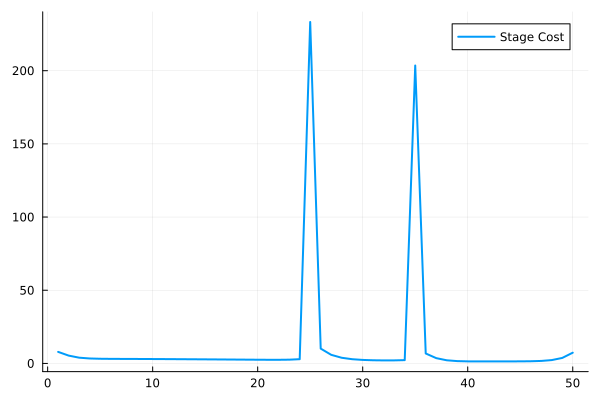

In [11]:
    # problem size 
    nx = 6 
    nu = 3 
    dt = 0.01
    tf = 0.5 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # LQR cost 
    Q = 10*diagm(ones(nx))
    R = 10*diagm(ones(nu))
    Qf = 10*diagm(ones(nx))
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states 
    xic = [deg2rad(45), -deg2rad(45), 0, 0, 0, 0]


    # fingertip_xg = [0.2, -0.1]
    # xg = pinv(fingertip_jacobian(fingertip_xgfingertip_xg))*
    xg = [deg2rad(30), -deg2rad(35), -deg2rad(25), 0.0, 0.0, 0.0]
 

    # mode index sets
    # M1 = vcat([1:50]...)
    # M2 = vcat([26:35]...)
    # M3 = vcat([36:50]...)
    M1 = vcat([1:50]...)
    M2 = vcat([26:35]...)
    M3 = vcat([36:50]...)
    # M2 = []
    # M3 = []

    J1 = [25]
    J2 = [35]
    # J1 = []
    # J2 = []
    
    
    # load all useful things into params 
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx, L1=0.1, L2=0.1,
     L3=0.1, m1=1.0, m2=1.0, m3=0.25, k=0.1, b=0.1, mkey=0.25, ykey=0.0, M1=M1, M2=M2, M3=M3, J1=J1, J2=J2)

# fingertip_cost(params, Xm_vec[1])

Zm = [Xm[:,1:end-1]; Um]
Zm_vec = [Vector(col) for col in eachcol(Zm)]
Zm_vec[1]

stage_cost_vec = zeros(length(Zm_vec))

stage_cost_vec = [stage_cost(params, Z) for Z in Zm_vec]
plot(stage_cost_vec, label="Stage Cost", linewidth=2)
# stage_cost(params, Zm_vec[1])
